In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
import pickle
import numpy as np
from functions import *
from queue import Queue
%matplotlib inline

In [16]:
svc = pickle.load(open("pickle/svc_9944.p", "rb"))
X_scaler = pickle.load(open("pickle/scaler_allimages.p", "rb"))

In [22]:
class Vdat():
    
    def __init__(self, ):
        
        self.y_start_stop = [320, 600]
        self.x_start_stop = [700, 1280]
        self.overlap = 0.5
        self.color_space = 'YCrCb'
        self.orient = 12
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.spatial_size = (16,16)
        self.hist_bins = 16
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True
        self.last_detection = (np.zeros((720, 1280), dtype=np.int32), 0)
        self.flag = False
        self.count = 0
        self.q = Queue()
        self.cumm_heatmap = None
        
    def add_heat(self, heatmap, bbox_list):

        for box in bbox_list:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        return heatmap

    def apply_threshold(self, heatmap, threshold):

        heatmap[heatmap <= threshold] = 0
        
        return heatmap

    def find_cars(self, img):
    
        draw_img = np.copy(img)
        coldmap = np.zeros_like(img[:,:,0])
        img = img.astype(np.float32)/255
        windows1 = slide_window(img, x_start_stop=self.x_start_stop, y_start_stop=self.y_start_stop,
                                xy_window = (128, 128), xy_overlap = (self.overlap, self.overlap))
        windows2 = slide_window(img, x_start_stop=self.x_start_stop, y_start_stop=self.y_start_stop,
                                xy_window = (64, 64), xy_overlap = (self.overlap, self.overlap))
        windows3 = slide_window(img, x_start_stop=self.x_start_stop, y_start_stop=self.y_start_stop,
                                xy_window = (96, 96), xy_overlap = (self.overlap, self.overlap))
        windows = windows1 + windows2 + windows3
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=self.color_space,
                                spatial_size=self.spatial_size, hist_bins=self.hist_bins, orient=self.orient,
                                pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block,
                                hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, hist_feat=self.hist_feat,
                                hog_feat=self.hog_feat)
        heatmap = self.add_heat(coldmap, hot_windows)
        thresholded_heatmap = self.apply_threshold(heatmap, threshold = 0)
        window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    
        return window_img, thresholded_heatmap
    
    def process_image(self, img):

        out_img, heatmap = self.find_cars(img)
        if(self.count == 0):
            self.cumm_heatmap = np.zeros_like(img[:,:,0])
        if (self.q.qsize() < 10):
            self.cumm_heatmap += heatmap
            self.q.put(heatmap)
        else:
            remove = self.q.get()            
            self.cumm_heatmap = self.cumm_heatmap - remove + heatmap
            self.q.put(heatmap)
        clipped_map = apply_threshold(self.cumm_heatmap, threshold = 0)
        labels = label(clipped_map)
        draw_img = draw_labeled_bboxes(np.copy(img), labels, self.flag)
#         self.flag = flag
        
#         if self.flag:
#             self.last_detection = labels
#         else:
#             draw_img, flag = draw_labeled_bboxes(np.copy(img), self.last_detection, self.flag)
        
        self.count += 1
#         print(draw_img)
        
        return draw_img

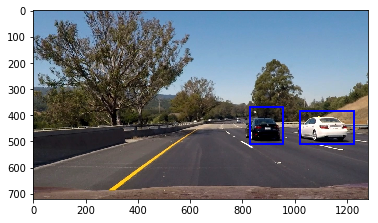

In [29]:
test_img = mpimg.imread('../test_images/test6.jpg')
detector = Vdat()
im = detector.process_image(test_img)
plt.imshow(im[0])

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip('../videos/project_video.mp4')
test_clip = clip.fl_image(detector.process_image).subclip(0,20)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4



 31%|███       | 155/501 [03:55<09:08,  1.58s/it]


 62%|██████▏   | 309/501 [07:57<04:58,  1.55s/it]


 92%|█████████▏| 463/501 [11:57<00:59,  1.57s/it]


100%|█████████▉| 500/501 [12:54<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

